# Gesture Recognizer 

This is initialization code. Most code here is Jon's. I have added properties `gyro_corr`  and `accel_corr` which will store the correlated data.

In [376]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import copy
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        #correlated accel signal
        self.accel_corr = copy.deepcopy(self.accel);
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
 
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
        #correlated gyro signal
        self.gyro_corr = copy.deepcopy(self.gyro);
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [377]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

##  Functions Used in Signal Processing

In [378]:
# Used to correlated signals (move to common beginning)
# shift_to_common is auxiliary

def shift_to_common(arrayToShift, truth):
    
    correlateAToB = signal.correlate(arrayToShift, truth)
    bestCorrelationPoint = np.argmax(correlateAToB)
    indexShift = len(arrayToShift) - bestCorrelationPoint
    result = np.roll(arrayToShift, indexShift)
    return result;

# Shifts shifts everything to common start
def correlate():
    index = 0
    xyz = ['x', 'y', 'z', 'mag']
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            for axis in xyz:
                oldVal = getattr(trial.accel, axis);
                truth = getattr(gestureTrials[0].accel, axis)
                newVal = shift_to_common(oldVal, truth)
                setattr(trial.accel_corr, axis, newVal)
                oldVal = getattr(trial.gyro, axis);
                truth = getattr(gestureTrials[0].gyro, axis)
                newVal = shift_to_common(oldVal, truth)
                setattr(trial.gyro_corr, axis, newVal)

            trialNum = trialNum + 1

        index = index + 1


In [379]:
# Function for smoothing the signal. Taken from http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
import numpy

def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

## Load the data


In [380]:
# Load the data
# To run this with my set of gestures uncomment my path and comment Jon's

logPathJon = '/Users/algendel/Desktop/__School/Projects/CSEP590/GestureRecognizer/JonGestureLogs'
logPathAlina = '/Users/algendel/Desktop/__School/Projects/CSEP590/GestureRecognizer/AlinaGestureLogs'
mapGestureToTrials = parse_and_create_gesture_trials(logPathJon)
mapGestureToTrialsAlina = parse_and_create_gesture_trials(logPathAlina)

Found 100 csv files in /Users/algendel/Desktop/__School/Projects/CSEP590/GestureRecognizer/JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 110 csv files in /Users/algendel/Desktop/__School/Projects/CSEP590/GestureRecognizer/AlinaGestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Mida

## Plot things

### Raw signals

In [381]:
# Plotting accel x, y, z, mag, and gyro mag.

# From now on I will only plot gyro and accel magnitude. x, y, & z are not reliable on their own. Magnitude should
# provide enough insight

def plot_signals(mapGestureToTrials): 
    fig, axes = plt.subplots(len(mapGestureToTrials), 5, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)
    correlate()
    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][4].plot(trial.gyro.mag,  alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Accel X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Accel Mag)")
        axes[index][3].legend()

        axes[index][4].set_title(gestureName + " (Gyro Mag)")
        axes[index][4].legend()

        index = index + 1

### Jon's Raw Signals

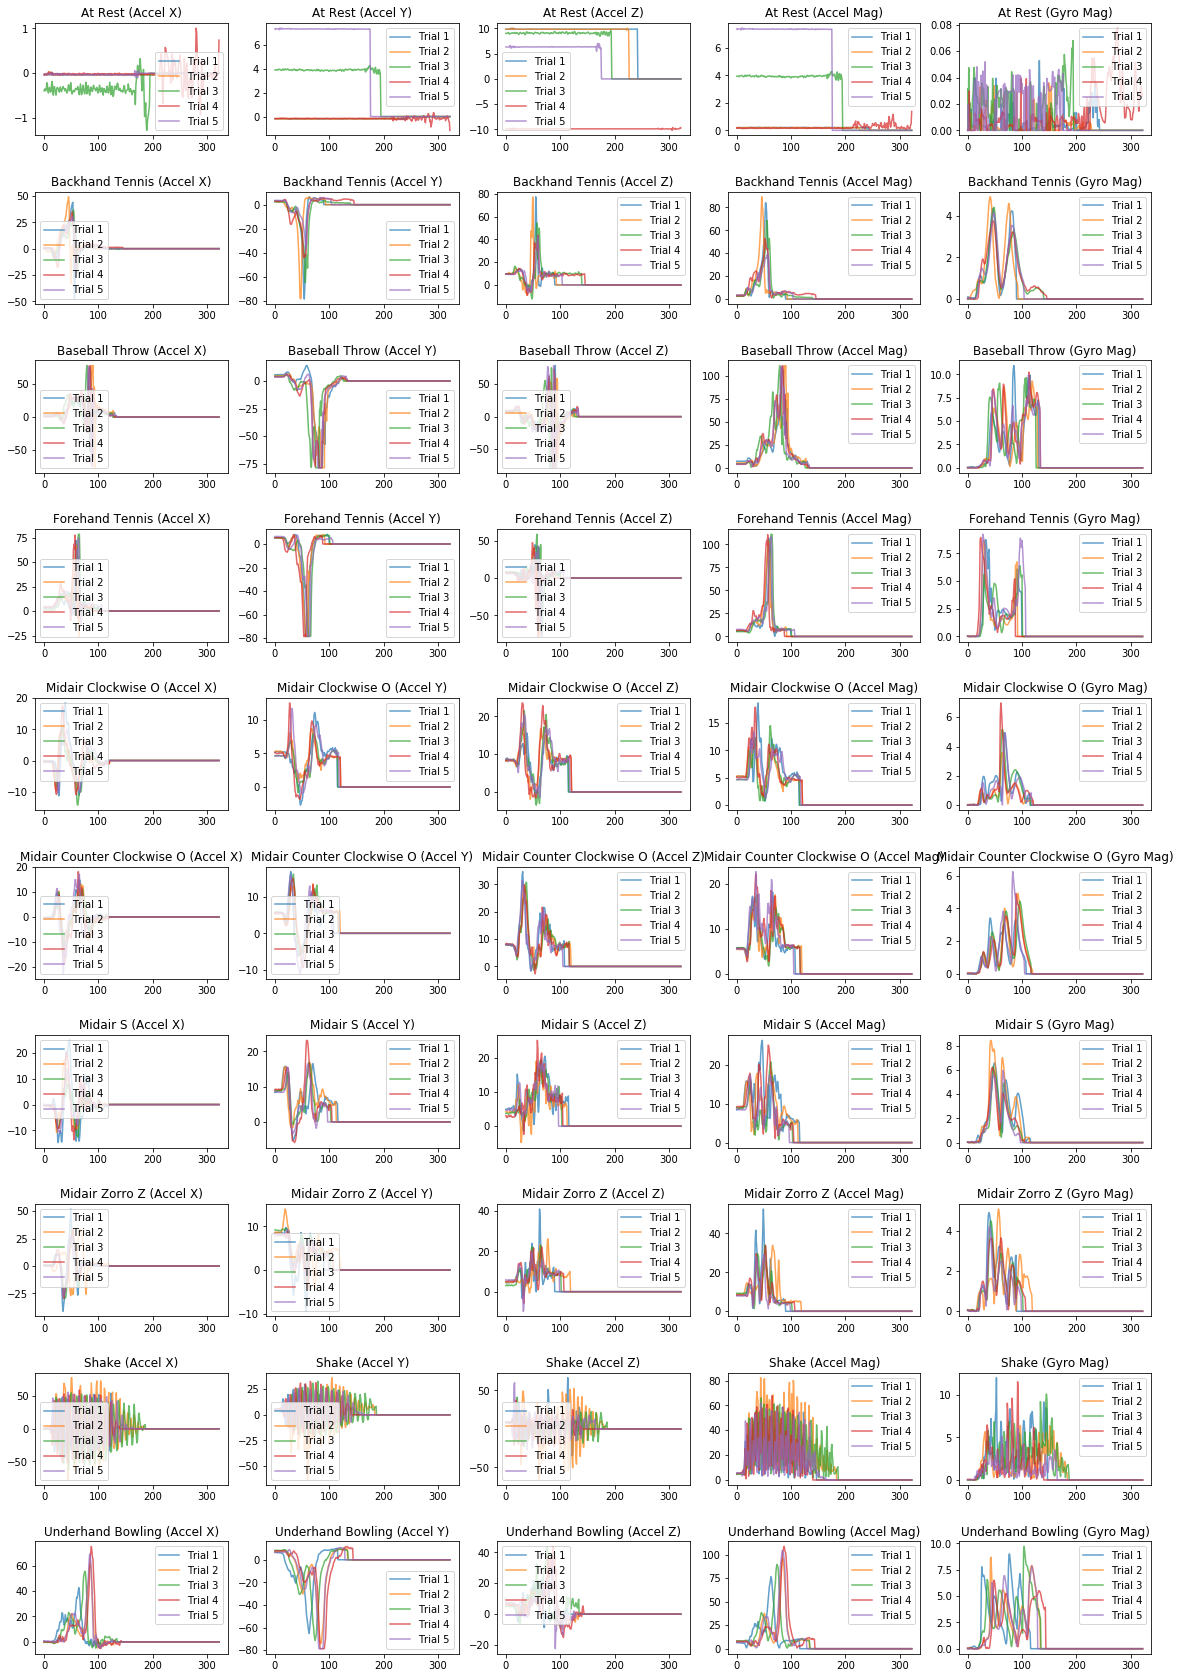

In [382]:
plot_signals(mapGestureToTrials)   

### Alina's Raw Signals

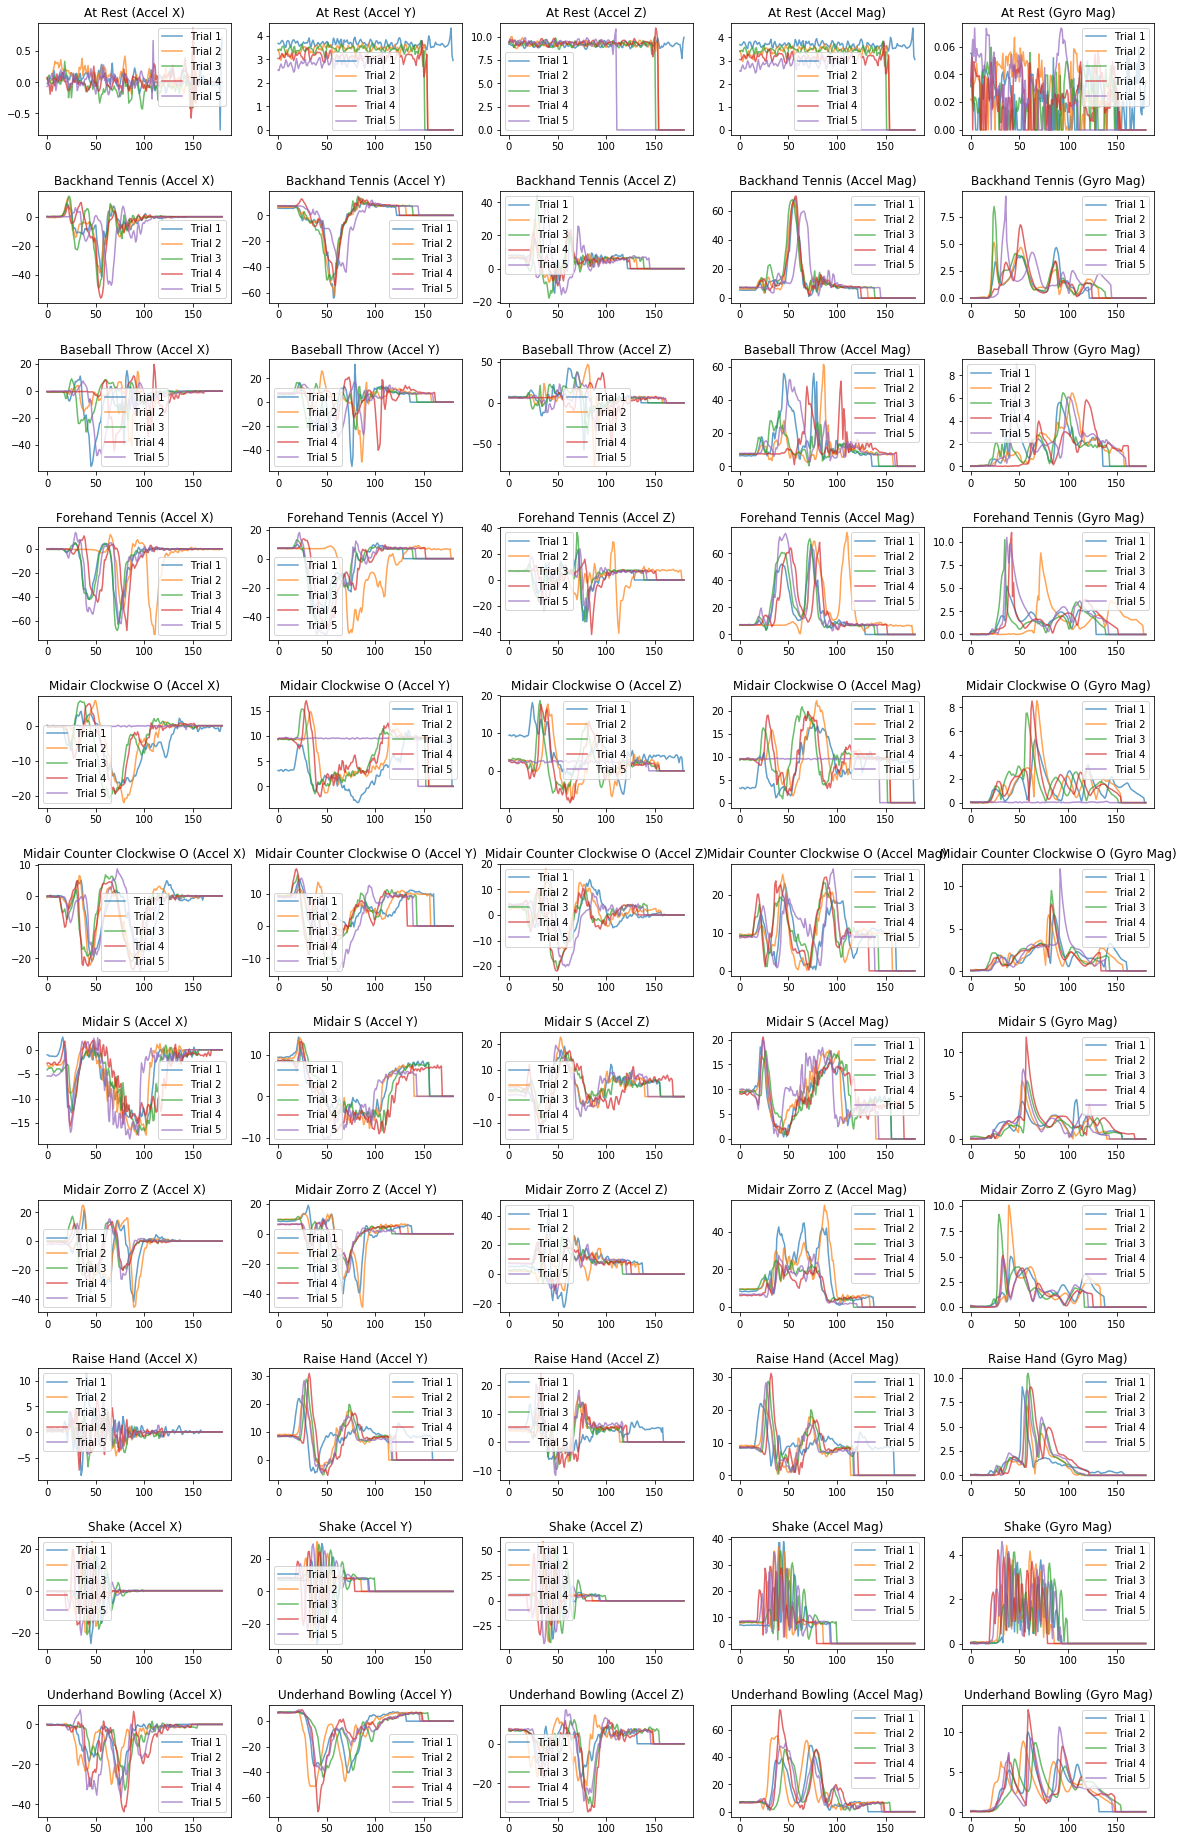

In [383]:
plot_signals(mapGestureToTrialsAlina)   

### Raw vs smoothed magnitudes for correlated acceleration and gyro

In [384]:
# Going to correlate accel and gyro magnitudes and plot them to see what they look like. 

def plot_signals_raw_smooth(mapGestureToTrials): 
    fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)
    correlate()
    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel_corr.mag, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(smooth(trial.accel_corr.mag), alpha=0.7, label="Trial {}".format(trialNum)) 
            axes[index][2].plot(trial.gyro_corr.mag, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(smooth(trial.gyro_corr.mag), alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Accel Mag)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Mag Smoothed Out)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Gryo Mag)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Gryo Mag Smoothed Out)")
        axes[index][3].legend()

        index = index + 1

### Compare Raw and Smoothed correlated Signals

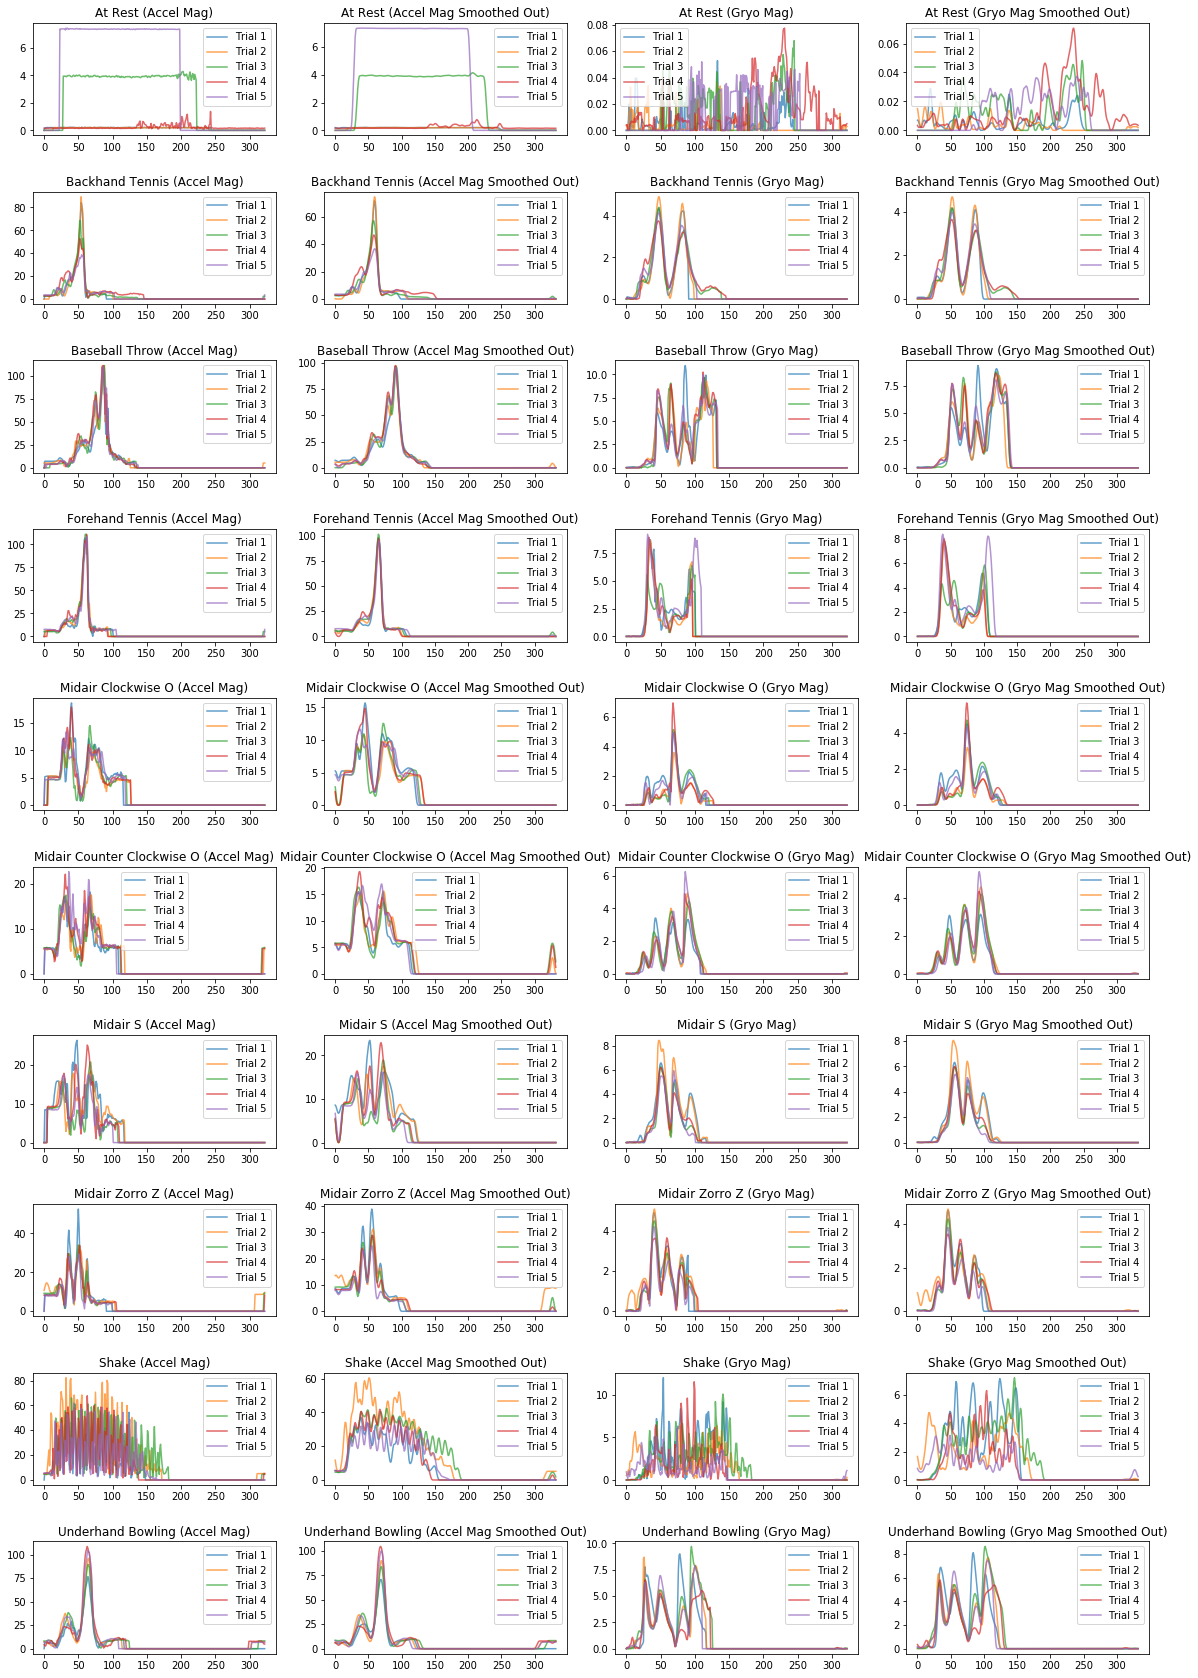

In [385]:
plot_signals_raw_smooth(mapGestureToTrials)

### Now for Spectral Density Plots

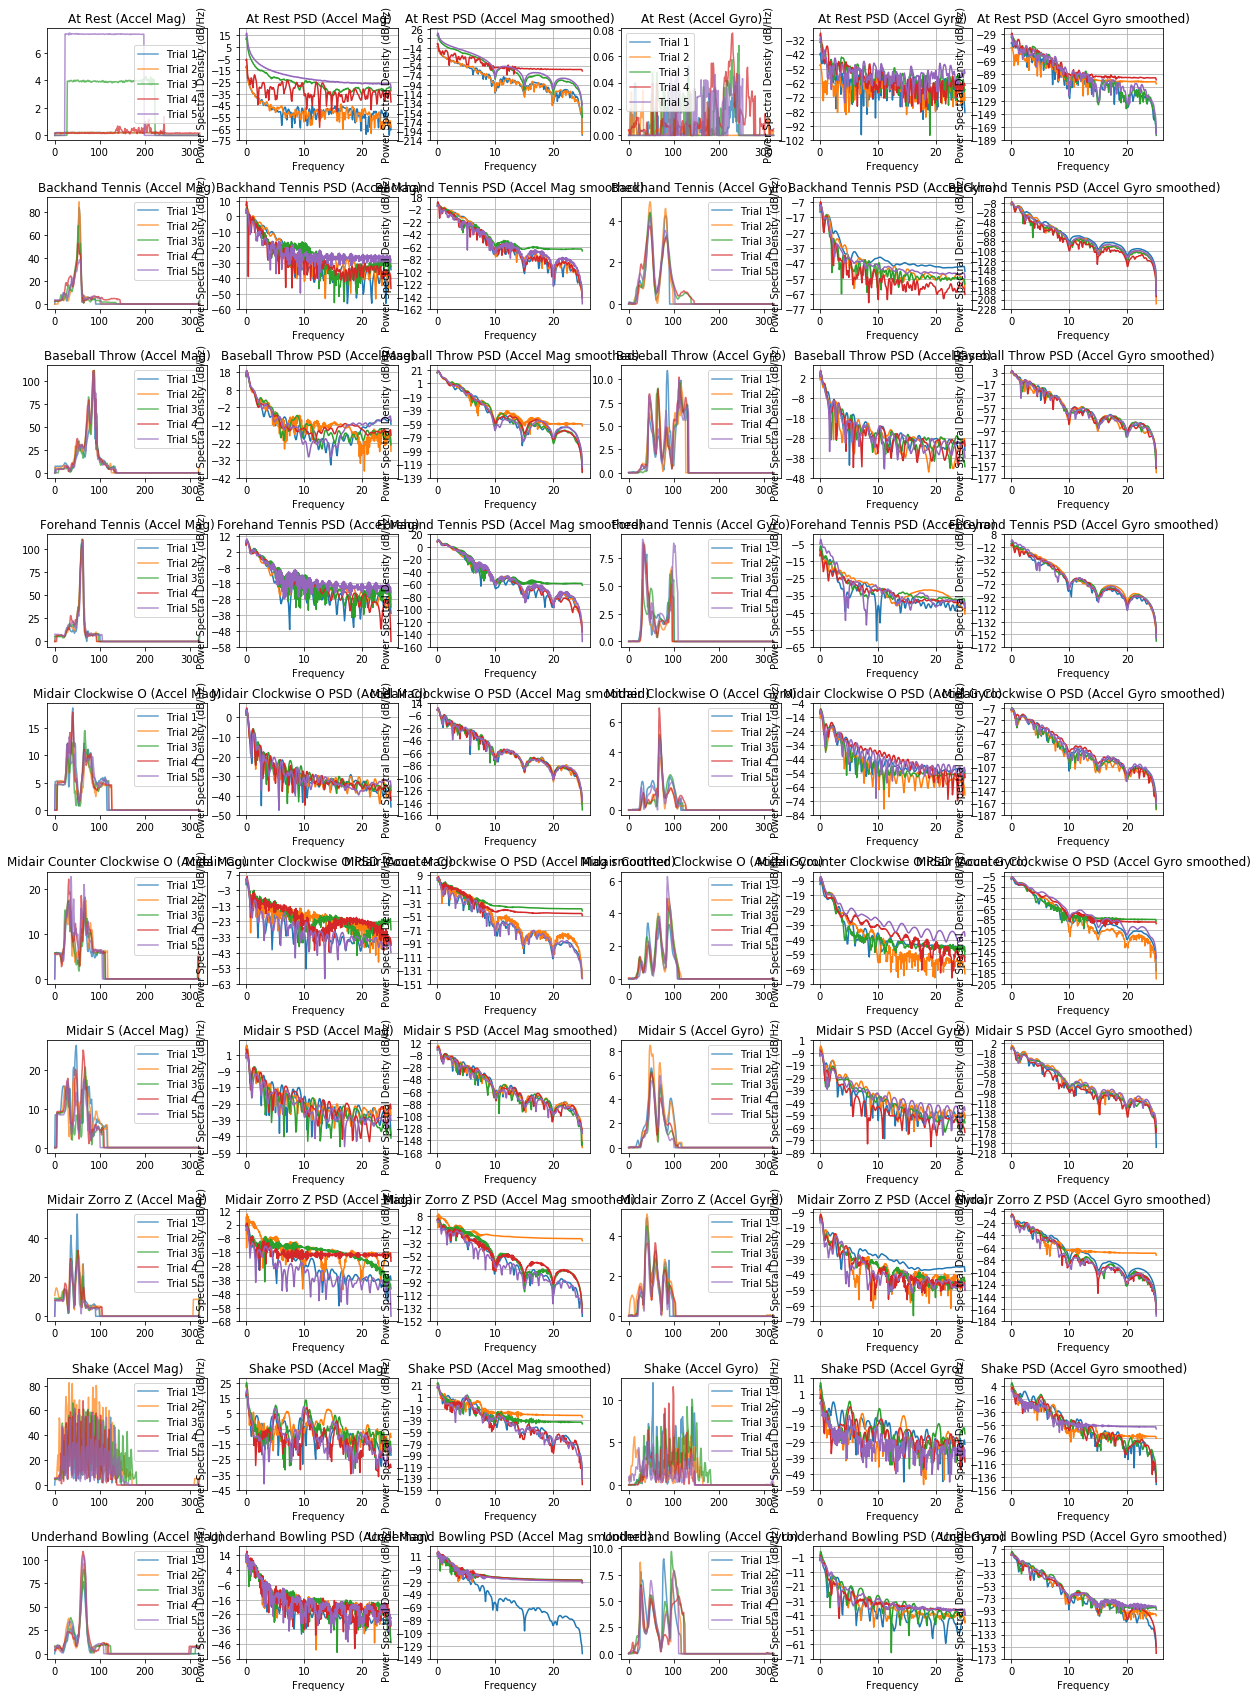

In [386]:
# Plotting spectral density of the raw and smoothed signal.

fig, axes = plt.subplots(len(mapGestureToTrials), 6, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)
correlate()
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:

        axes[index][0].plot(trial.accel_corr.mag,  alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].psd(trial.accel_corr.mag,  NFFT=512, Fs=50)
        axes[index][2].psd(smooth(trial.accel_corr.mag),  NFFT=512, Fs=50)
        axes[index][3].plot(trial.gyro_corr.mag,  alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][4].psd(trial.gyro_corr.mag,  NFFT=512, Fs=50)
        axes[index][5].psd(smooth(trial.gyro_corr.mag),  NFFT=512, Fs=50)

        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel Mag)")
    axes[index][0].legend()
    axes[index][1].set_title(gestureName + " PSD (Accel Mag)")
    axes[index][2].set_title(gestureName + " PSD (Accel Mag smoothed)")
    axes[index][3].set_title(gestureName + " (Accel Gyro)")
    axes[index][3].legend()
    axes[index][4].set_title(gestureName + " PSD (Accel Gyro)")
    axes[index][5].set_title(gestureName + " PSD (Accel Gyro smoothed)")
    index = index + 1

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


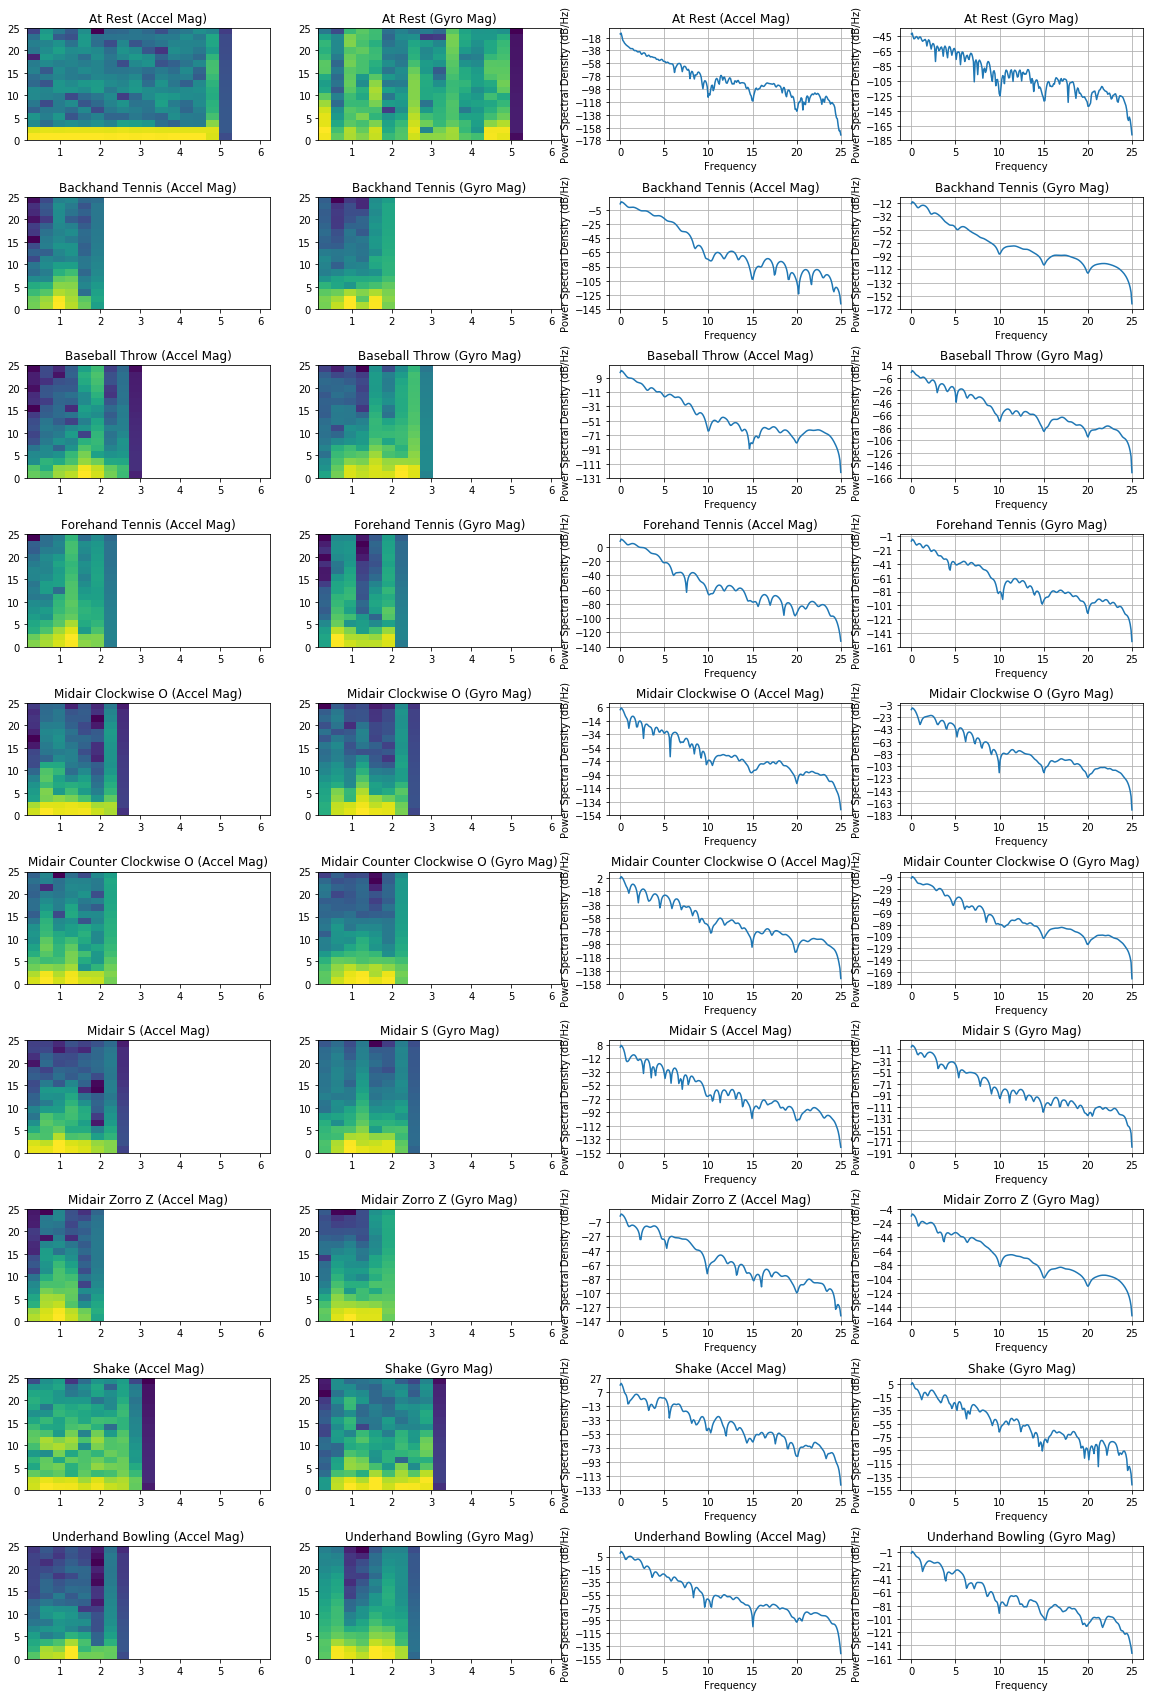

In [387]:

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)
correlate()
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    axes[index][0].specgram(gestureTrials[0].accel.mag, NFFT=32, Fs=50, noverlap=16)
    axes[index][1].specgram(gestureTrials[0].gyro.mag, NFFT=32, Fs=50, noverlap=16)
    axes[index][2].psd(smooth(gestureTrials[0].accel.mag),  NFFT=512, Fs=50)
    axes[index][3].psd(smooth(gestureTrials[0].gyro.mag),  NFFT=512, Fs=50)
    axes[index][0].set_title(gestureName + " (Accel Mag)")
    axes[index][1].set_title(gestureName + " (Gyro Mag)")
    axes[index][2].set_title(gestureName + " (Accel Mag)")
    axes[index][3].set_title(gestureName + " (Gyro Mag)")
    index = index + 1

## 2D scatter plots of various combinations

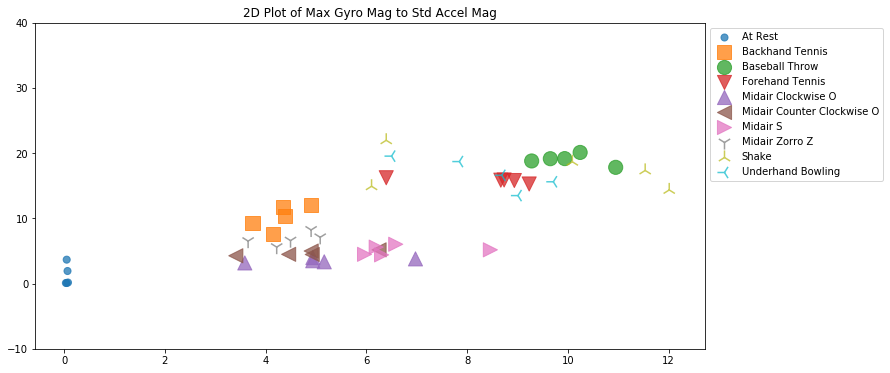

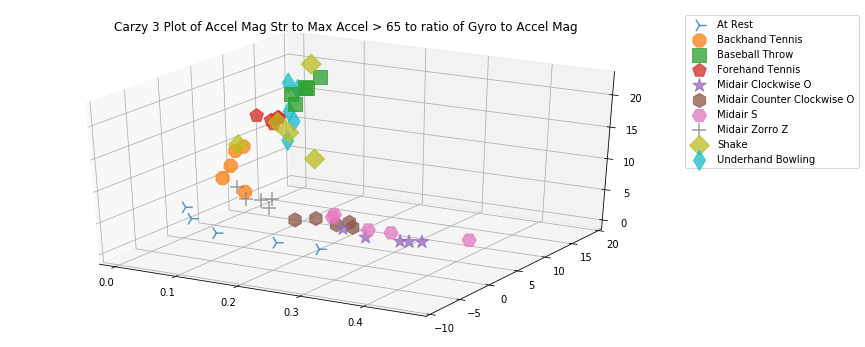

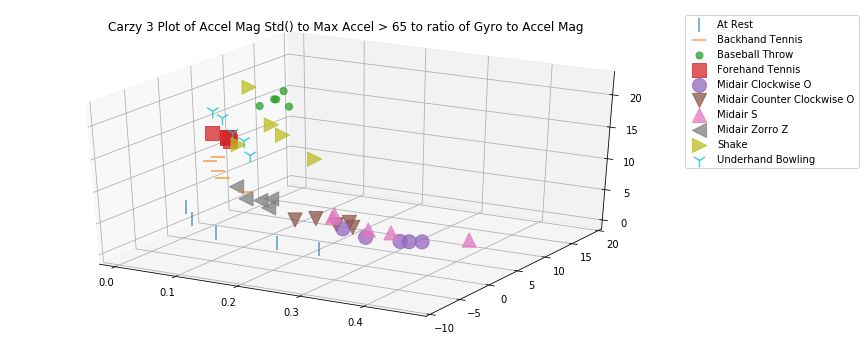

In [388]:

from scipy import signal
import numpy as np

    
from mpl_toolkits.mplot3d import Axes3D



import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

def gyroAccelMax(trial): 
    index = 0
    accelMagVal = 65
    gyroMagVal = 3.5
    counter = 0;
    for point in trial.accel.mag:
        if point > accelMagVal:
            if trial.gyro.mag[index] > gyroMagVal:
                counter = counter + 1
        index = index + 1
    return counter
    
    
    
    

markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)


def scatter_2d_1(mapGestureToTrials):  
    #max gyro mag to std accel mag
    plt.figure(figsize=(12, 6))
    for gestureName, trials in mapGestureToTrials.items():

        x = list(trial.gyro.mag.max() for trial in trials)
        y = list(trial.accel.mag.std() for trial in trials)    
        s = [200] * len(x)
        plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

    plt.ylim((-10,40))
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
    plt.title("2D Plot of Max Gyro Mag to Std Accel Mag")
    plt.show()
    

def scatter_3d_1(mapGestureToTrials): 
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    for gestureName, trials in mapGestureToTrials.items():

        x = list(trial.accel.mag.max() for trial in trials)
        x1 = list(trial.gyro.mag.max() for trial in trials)
        x = np.divide(x1, x)

        mag_65 = []

        for trial in trials:
            m_65 = len(list(filter(lambda x: x >  65, trial.accel.mag)))
            mag_65 = np.append(mag_65, m_65)
        y = list(mag_65)
        s = [200] * len(x)
        z = list(trial.accel.mag.std() for trial in trials)

        ax.scatter(x, y, z, alpha=0.75, marker=next(marker), s=s, label=gestureName)

    plt.ylim(-10,20)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
    plt.title("Carzy 3 Plot of Accel Mag Str to Max Accel > 65 to ratio of Gyro to Accel Mag")
    plt.show()    

def scatter_3d_2(mapGestureToTrials): 
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    for gestureName, trials in mapGestureToTrials.items():

        x = list(trial.accel.mag.max() for trial in trials)
        x1 = list(trial.gyro.mag.max() for trial in trials)
        x = np.divide(x1, x)

        mag_65_g = []

        for trial in trials:
            m_65_g = gyroAccelMax(trial)
            mag_65_g = np.append(mag_65_g, m_65_g)
        y = list(mag_65_g)
        s = [200] * len(x)
        z = list(trial.accel.mag.std() for trial in trials)

        ax.scatter(x, y, z, alpha=0.75, marker=next(marker), s=s, label=gestureName)

    plt.ylim(-10,20)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
    plt.title("Carzy 3 Plot of Accel Mag Std() to Max Accel > 65 to ratio of Gyro to Accel Mag")
    plt.show()
    
scatter_2d_1(mapGestureToTrials)
scatter_3d_1(mapGestureToTrials)
scatter_3d_2(mapGestureToTrials)



###  Functions for generating folds and results used in both template matching and SVM

In [389]:
#Lets create the folds

from random import shuffle

def get_folds (mapGestureToTrials) :
    gestureNamesSorted = sorted(mapGestureToTrials.keys())

    folds = [list(), list(), list(), list(), list()]
    index = 0
    for gestureName in gestureNamesSorted:
        gestureTrials = copy.deepcopy(mapGestureToTrials[gestureName]);
        shuffle(gestureTrials)
        trialIndex = 0
        for trial in gestureTrials:
            folds[trialIndex].append(trial)
            trialIndex = trialIndex+1;

        index = index + 1

    index = 0
    return folds

folds = get_folds(mapGestureToTrials)

In [390]:

# this is where we are going to store the results
# since all gestures are represented in fold - we'll just pass the first fold to id
def create_gesture_results_dictionary(fold):
    gestureDictionary = {}
    for gestureTrial in fold:
        #key is the name with _ instead of spaces
        gestureDictionary[gestureTrial.gestureName.replace(" ", "_")] = {"gname": gestureTrial.gestureName, "matches": list()}
    return gestureDictionary

### SVM creation and training

In [391]:
# Now, let's try to build an SVM 
from scipy.integrate import simps
from numpy import trapz

from sklearn import svm

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)

folds = get_folds(mapGestureToTrials)
gestureNames = list(mapGestureToTrials.keys())

foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()

def train_it(foldList):
    classLabels = np.array([])
    high_mag_peak=[]
    for fold in foldList:
        for trial in fold:
            high_mag_peak = len(list(filter(lambda x: x >  65, trial.accel.mag)))
            gradient= (np.gradient(trial.accel.mag)).max()
            area = trapz(trial.gyro.mag, dx=5)
            features = np.append(np.append([trial.gyro.mag.max(), trial.accel.mag.std(), high_mag_peak, gradient, area], trial.accel.mag), trial.gyro.mag)
            if i2==0:
                trainingData = [features]
            else:
                trainingData = np.append(trainingData, [features], axis = 0)
            classLabels = np.append(classLabels, trial.gestureName)
    return trainingData,  classLabels

 
def find_ml(trial, trainFolds):
    data, labels = train_it(trainFolds)

    clf = svm.SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
    clf.fit(data, labels)
   
    high_mag_peak = len(list(filter(lambda x: x >  65, trial.accel.mag)))
    gradient= (np.gradient(trial.accel.mag)).max()
    area = trapz(trial.gyro.mag, dx=5)

    features =np.append(np.append([trial.gyro.mag.max(), trial.accel.mag.std(), high_mag_peak, gradient, area], trial.accel.mag), trial.gyro.mag)
    svmPrediction = clf.predict([features])
    return svmPrediction[0]
    

### DTW Distance determination

In [392]:
#This is where we find the closest gesture

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

# This finds the closest in each individual fold. This is not implementation that is required but I am leaving it in 
# in case I'm wrong
def find_closest_old (source, foldsList):
    lst = [None] * len(foldsList)
    
    closest = 10000000
    index = 0
    trial_ = ""
    distance = 100000
    for fold in foldsList:
        #print("doing fold {}".format(index)); 
        closest = 10000000
        trial_ = ""
        distance = 100000
        for trial in fold:

            distance, path = fastdtw(trial.accel_corr.mag, source.accel_corr.mag)
            if distance < closest:
                closest = distance
                trial_ = trial.gestureName
                lst[index] = trial.gestureName      
        #print("closest to {} is {} with distance {}".format(source.gestureName, trial_, distance ))
        index = index + 1
     
    return lst


def find_closest (source, foldsList):
    lst = [None] * len(foldsList)
    closest = 10000000
    index = 0
    trial_ = ""
    distance = 100000
    trial_ = ""
    winning_fold_index = -1
    #print("---------------------------------------------------------")
    #print("Finding matches for {}".format(source.gestureName))
    for fold in foldsList:
        #print("doing fold {}".format(index)); 
        for trial in fold:
            distance, path = fastdtw(trial.accel_corr.x, source.accel_corr.x)
            if distance < closest:
                closest = distance
                trial_ = trial.gestureName
                lst[index] = trial.gestureName 
                winning_fold_index = index
        index = index + 1
    return trial_

In [393]:
#this is our runner that will populate the results
def run_me(testFold, templateFolds, index, results_dictionary, _type):
    for gestureTrial in testFold:
        currentGestureName = gestureTrial.gestureName
        currentResultsKey = currentGestureName.replace(" ", "_")
        #print(currentResultsKey)
        if(_type == 0):
            result = find_closest (gestureTrial, templateFolds)
        else:
            result= find_ml(gestureTrial, templateFolds)
        #print("For fold {} for gesture {} we have a result{}".format(index, currentGestureName, result))
        dictionaryEntry = results_dictionary[currentResultsKey]
        #print(result)
        #print(dictionaryEntry)
        dictionaryEntry["matches"].append(result);
        
    return results_dictionary

def get_correct_answers(key, results_dictionary):
    item = results_dictionary[key]
    correctAnswers = len(list(filter(lambda x: x == item["gname"], item["matches"])))
    return correctAnswers

def print_results(folds, results_dictionary, title):
 
    result = 0
    total_gestures = len(folds)*len(folds[0])

    for key in results_dictionary:
        result = result + get_correct_answers(key, results_dictionary);


    print(title.format(result, total_gestures, round(result/total_gestures, 2)*100))
    print("---------------------------------------------------------")

    for key in results_dictionary:
        correctAnswers = get_correct_answers(key,  results_dictionary)
        print("{} {}/{} {}%".format(results_dictionary[key]["gname"], correctAnswers, len(folds), round(correctAnswers/len(folds), 2) * 100))
      

    

def main_runner(folds, _type): 
    results_dictionary = create_gesture_results_dictionary(folds[0])
    index = 0
    for testFold in folds:
        #testFold = folds[0]
        if 4>index > 1:
            #templateFolds = folds[1:]
            templateFolds = folds[0:index]+folds[index+1:]
        elif index == 4:
            templateFolds = folds[0:4]
        else:
            templateFolds = folds[1:]

        results = run_me(testFold, templateFolds, index, results_dictionary, _type)

        index = index + 1
    return results


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def build_confusion_matrix(results_dictionary): 
    i = 0
    _true = list()
    _pred = list()
    _labels = list()
    for key in results_dictionary:
        name = results_dictionary[key]['gname']
        matches = results_dictionary[key]['matches']
        _labels = np.append(_labels, name)
        for match in matches:
            _true = np.append(_true, name)
            _pred = np.append(_pred, match)
        i = i +1

    return list(_true), list(_pred), list(_labels)
    



##### Result trends
* trial.accel.mag.max(), trial.gyro.mag.std()  64%
* trial.gyro.mag.var(), trial.accel.mag.var() 52%
* trial.gyro.mag.std(), trial.accel.mag.var() 52%
* trial.gyro.mag.max(), trial.accel.mag.std() 72?


## RESULTS

In [394]:
from sklearn.metrics import confusion_matrix

foldsJon = get_folds(mapGestureToTrials)
foldsAlina = get_folds(mapGestureToTrialsAlina)

jonResultsSTV = main_runner(foldsJon, 1)
jonResultsDTW = main_runner(foldsJon, 0)

alinaResultsSTV = main_runner(foldsAlina, 1)
alinaResultsDTW = main_runner(foldsAlina, 0)

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new le

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
trai

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
trai

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new le

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
trai

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
trai

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
trai

old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
old length162 diff 38
train new length200
TEST162


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


old length76 diff 124
train new length200
old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train new length200
old length48 diff 152
train new length200
old length78 diff 122
train new length200
old length91 diff 109
train new length200
old length62 diff 138
train new length200
old length72 diff 128
train new length200
old length70 diff 130
train new length200
old length73 diff 127
train new length200
old length67 diff 133
train new length200
old length79 diff 121
train new length200
old length68 diff 132
train new length200
old length60 diff 140
train new length200
old length51 diff 149
train new length200
old length67 diff 133
train new length200
old length78 diff 122
train new length200
old length63 diff 137
train new le

old length75 diff 125
train new length200
old length56 diff 144
train new length200
old length67 diff 133
train new length200
old length69 diff 131
train new length200
old length77 diff 123
train new length200
old length78 diff 122
train new length200
old length72 diff 128
train new length200
old length71 diff 129
train new length200
old length64 diff 136
train new length200
old length59 diff 141
train new length200
old length47 diff 153
train new length200
old length75 diff 125
train new length200
TEST91
old length76 diff 124
train new length200
old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train new length200
old length48 diff 152
train new length200
old length78 diff 122
train new length200
old length91 diff 109
train

old length72 diff 128
train new length200
old length70 diff 130
train new length200
old length73 diff 127
train new length200
old length67 diff 133
train new length200
old length79 diff 121
train new length200
old length68 diff 132
train new length200
old length60 diff 140
train new length200
old length51 diff 149
train new length200
old length67 diff 133
train new length200
old length78 diff 122
train new length200
old length63 diff 137
train new length200
old length80 diff 120
train new length200
old length65 diff 135
train new length200
old length90 diff 110
train new length200
old length79 diff 121
train new length200
old length72 diff 128
train new length200
old length61 diff 139
train new length200
old length62 diff 138
train new length200
old length40 diff 160
train new length200
old length75 diff 125
train new length200
old length56 diff 144
train new length200
old length67 diff 133
train new length200
old length69 diff 131
train new length200
old length77 diff 123
train new le

old length40 diff 160
train new length200
old length75 diff 125
train new length200
old length56 diff 144
train new length200
old length67 diff 133
train new length200
old length69 diff 131
train new length200
old length77 diff 123
train new length200
old length78 diff 122
train new length200
old length72 diff 128
train new length200
old length71 diff 129
train new length200
old length64 diff 136
train new length200
old length59 diff 141
train new length200
old length47 diff 153
train new length200
old length75 diff 125
train new length200
TEST91
old length76 diff 124
train new length200
old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train new length200
old length48 diff 152
train new length200
old length78 diff 122
train

old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train new length200
old length48 diff 152
train new length200
old length78 diff 122
train new length200
old length78 diff 122
train new length200
old length63 diff 137
train new length200
old length80 diff 120
train new length200
old length65 diff 135
train new length200
old length90 diff 110
train new length200
old length79 diff 121
train new length200
old length72 diff 128
train new length200
old length61 diff 139
train new length200
old length62 diff 138
train new length200
old length40 diff 160
train new length200
old length75 diff 125
train new length200
old length56 diff 144
train new length200
old length67 diff 133
train new length200
old length69 diff 131
train new le

old length40 diff 160
train new length200
old length75 diff 125
train new length200
old length56 diff 144
train new length200
old length67 diff 133
train new length200
old length69 diff 131
train new length200
old length77 diff 123
train new length200
old length78 diff 122
train new length200
old length72 diff 128
train new length200
old length71 diff 129
train new length200
old length64 diff 136
train new length200
old length59 diff 141
train new length200
old length47 diff 153
train new length200
old length75 diff 125
train new length200
TEST91
old length78 diff 122
train new length200
old length73 diff 127
train new length200
old length82 diff 118
train new length200
old length72 diff 128
train new length200
old length78 diff 122
train new length200
old length70 diff 130
train new length200
old length79 diff 121
train new length200
old length70 diff 130
train new length200
old length58 diff 142
train new length200
old length44 diff 156
train new length200
old length74 diff 126
train

old length64 diff 136
train new length200
old length59 diff 141
train new length200
old length47 diff 153
train new length200
old length75 diff 125
train new length200
TEST91
old length78 diff 122
train new length200
old length73 diff 127
train new length200
old length82 diff 118
train new length200
old length72 diff 128
train new length200
old length78 diff 122
train new length200
old length70 diff 130
train new length200
old length79 diff 121
train new length200
old length70 diff 130
train new length200
old length58 diff 142
train new length200
old length44 diff 156
train new length200
old length74 diff 126
train new length200
old length76 diff 124
train new length200
old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train

old length68 diff 132
train new length200
old length60 diff 140
train new length200
old length51 diff 149
train new length200
old length67 diff 133
train new length200
old length78 diff 122
train new length200
old length63 diff 137
train new length200
old length80 diff 120
train new length200
old length65 diff 135
train new length200
old length90 diff 110
train new length200
old length79 diff 121
train new length200
old length72 diff 128
train new length200
old length61 diff 139
train new length200
old length62 diff 138
train new length200
old length40 diff 160
train new length200
old length75 diff 125
train new length200
TEST91
old length78 diff 122
train new length200
old length73 diff 127
train new length200
old length82 diff 118
train new length200
old length72 diff 128
train new length200
old length78 diff 122
train new length200
old length70 diff 130
train new length200
old length79 diff 121
train new length200
old length70 diff 130
train new length200
old length58 diff 142
train

old length75 diff 125
train new length200
TEST91
old length78 diff 122
train new length200
old length73 diff 127
train new length200
old length82 diff 118
train new length200
old length72 diff 128
train new length200
old length78 diff 122
train new length200
old length70 diff 130
train new length200
old length79 diff 121
train new length200
old length70 diff 130
train new length200
old length58 diff 142
train new length200
old length44 diff 156
train new length200
old length74 diff 126
train new length200
old length76 diff 124
train new length200
old length70 diff 130
train new length200
old length81 diff 119
train new length200
old length90 diff 110
train new length200
old length77 diff 123
train new length200
old length81 diff 119
train new length200
old length85 diff 115
train new length200
old length59 diff 141
train new length200
old length80 diff 120
train new length200
old length48 diff 152
train new length200
old length78 diff 122
train new length200
old length91 diff 109
train

### Shape Matching Results from Jon's gestures

----------------------------------------------------------------------------------
Using DTW with previously correlated graphs the Accuracy is 49/50 98.0%
---------------------------------------------------------
At Rest 5/5 100.0%
Backhand Tennis 5/5 100.0%
Baseball Throw 5/5 100.0%
Forehand Tennis 5/5 100.0%
Midair Clockwise O 5/5 100.0%
Midair Counter Clockwise O 5/5 100.0%
Midair S 4/5 80.0%
Midair Zorro Z 5/5 100.0%
Shake 5/5 100.0%
Underhand Bowling 5/5 100.0%
----------------------------------------------------------------------------------
Confusion matrix, without normalization


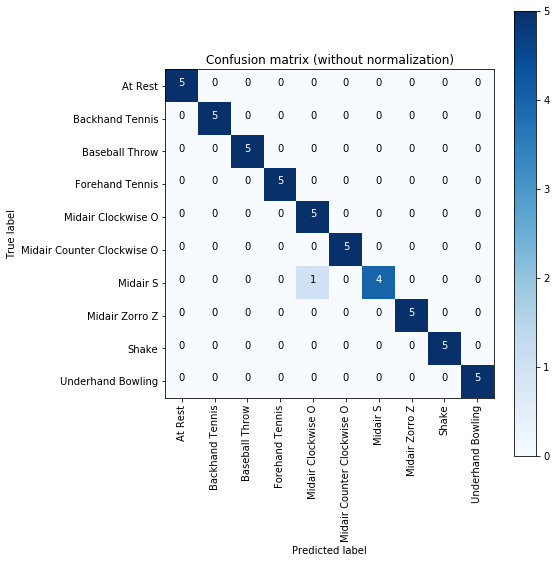

In [395]:
print("----------------------------------------------------------------------------------")

print_results(foldsJon, jonResultsDTW, "Using DTW with previously correlated graphs the Accuracy is {}/{} {}%")
print("----------------------------------------------------------------------------------")

_true, _pred, labels = build_confusion_matrix(jonResultsDTW)
cm = confusion_matrix(_true, _pred, labels)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix (without normalization)')
plt.show()

## Shape Matching Results from Alina's Gestures

----------------------------------------------------------------------------------
Using DTW with previously correlated graphs the Accuracy is 52/55 95.0%
---------------------------------------------------------
At Rest 5/5 100.0%
Backhand Tennis 5/5 100.0%
Baseball Throw 3/5 60.0%
Forehand Tennis 5/5 100.0%
Midair Clockwise O 4/5 80.0%
Midair Counter Clockwise O 5/5 100.0%
Midair S 5/5 100.0%
Midair Zorro Z 5/5 100.0%
Raise Hand 5/5 100.0%
Shake 5/5 100.0%
Underhand Bowling 5/5 100.0%
----------------------------------------------------------------------------------
Confusion matrix, without normalization


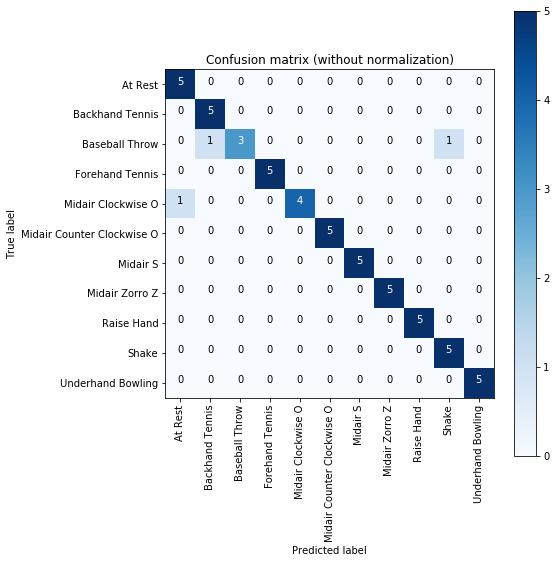

In [396]:
print("----------------------------------------------------------------------------------")

print_results(foldsAlina, alinaResultsDTW, "Using DTW with previously correlated graphs the Accuracy is {}/{} {}%")
print("----------------------------------------------------------------------------------")

_true, _pred, labels = build_confusion_matrix(alinaResultsDTW)
cm = confusion_matrix(_true, _pred, labels)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix (without normalization)')
plt.show()

### STV Results from Jon's gestures

----------------------------------------------------------------------------------
Using STV graphs the Accuracy is 41/50 82.0%
---------------------------------------------------------
At Rest 5/5 100.0%
Backhand Tennis 3/5 60.0%
Baseball Throw 5/5 100.0%
Forehand Tennis 4/5 80.0%
Midair Clockwise O 4/5 80.0%
Midair Counter Clockwise O 5/5 100.0%
Midair S 5/5 100.0%
Midair Zorro Z 3/5 60.0%
Shake 3/5 60.0%
Underhand Bowling 4/5 80.0%
Confusion matrix, without normalization


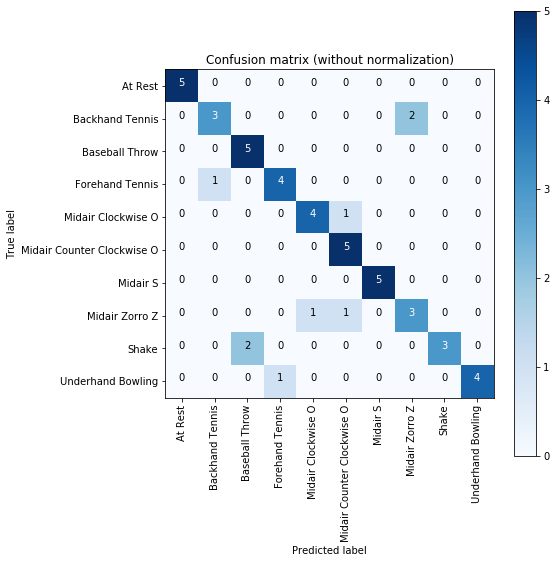

In [397]:
print("----------------------------------------------------------------------------------")
print_results(foldsJon, jonResultsSTV, "Using STV graphs the Accuracy is {}/{} {}%")
_true, _pred, labels = build_confusion_matrix(jonResultsSTV)
cm = confusion_matrix(_true, _pred, labels)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix (without normalization)')
plt.show()


### STV Results from Alina's Gestures

----------------------------------------------------------------------------------
Using STV graphs the Accuracy is 45/55 82.0%
---------------------------------------------------------
At Rest 5/5 100.0%
Backhand Tennis 4/5 80.0%
Baseball Throw 2/5 40.0%
Forehand Tennis 3/5 60.0%
Midair Clockwise O 4/5 80.0%
Midair Counter Clockwise O 4/5 80.0%
Midair S 4/5 80.0%
Midair Zorro Z 5/5 100.0%
Raise Hand 4/5 80.0%
Shake 5/5 100.0%
Underhand Bowling 5/5 100.0%
Confusion matrix, without normalization


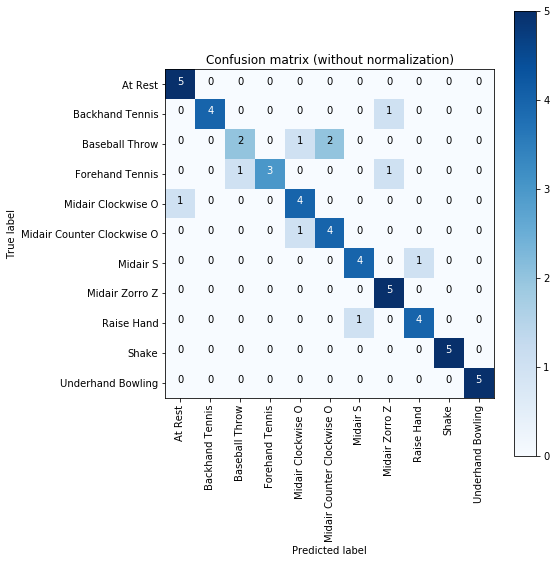

In [398]:
print("----------------------------------------------------------------------------------")
print_results(foldsAlina, alinaResultsSTV, "Using STV graphs the Accuracy is {}/{} {}%")
_true, _pred, labels = build_confusion_matrix(alinaResultsSTV)
cm = confusion_matrix(_true, _pred, labels)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix (without normalization)')
plt.show()
